In [1]:
import config
import numpy as np 
import matplotlib.pyplot as plt
from aml import graph_layout
import torch
from sklearn import decomposition
from sklearn import manifold
from Alg.solving_algorithm import ModelGenerator
from CustomModels.my_models import Integrator,renormolize_distribution
import os
from Losses.Losses import *
from tqdm import tqdm
from aml.plotting import *
from matplotlib import cm
import matplotlib
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import pandas as pd
def latex_float(number,precision=2):
    float_str = ''
    if precision == 3:
        float_str="{0:.3g}".format(number)
    if precision == 2:
        float_str="{0:.2g}".format(number)
    if precision == 1:
        float_str="{0:.1g}".format(number)
    if precision == 4:
        float_str="{0:.4g}".format(number)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return '$'+r"{0} \times 10^{{{1}}}".format(base, int(exponent))+'$'
    else:
        return float_str

def set_font_size_to(ax,font_size=None):
    if font_size is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(font_size)

def save_plot_to(fig, path):
    fig.savefig(path, bbox_inches = 'tight')

2024-04-21 17:21:20.845975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 17:21:20.846009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 17:21:20.846042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 17:21:20.852130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:21:21.597918: W tensorflow/compiler/

In [2]:
path_to_save = config.plots_path

In [3]:
path_to_save

'/home/user/lab_2023_controller_data/plots'

In [19]:
N = 1000 
adj_m = torch.load(config.Phi_adj_matrix)
all_distances = np.zeros(shape=(int(N*(N-1)/2),))
k_ = 0
for i in range(N-1):
    for j in range(i+1,N):
        all_distances[k_] = adj_m[i][j]
        k_ +=1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0.0
num of duplicates  7568


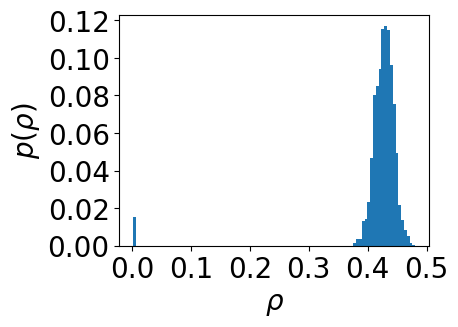

In [21]:
fig,ax = plot_float_distribution(all_distances,
                                 x_label=r'$\rho$',
                                 title= '',
                                 y_label=r'$p(\rho)$',
                                 font_size=20
                                 )
save_plot_to(fig, os.path.join(path_to_save,'rho_distr.png'))
print(np.sort(all_distances)[:100])
print(np.percentile(all_distances,1))
print('num of duplicates ',np.sum(all_distances==0))

In [22]:
gr_model = graph_layout.GraphOnAPlane(adj_m,size_of_output_space = 5)
gr_model.fit()

using device cpu


100%|██████████| 550/550 [00:51<00:00, 10.69it/s]

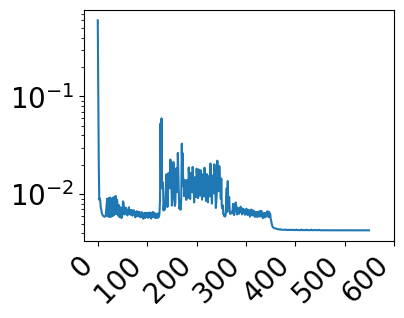

In [23]:
fig,ax = gr_model.plot_loss(rotation=45)
ax.set_ylabel('')
ax.set_xlabel('')
fig.set_size_inches(4,3)
set_font_size_to(ax,20)
save_plot_to(fig, os.path.join(path_to_save, 'grad_descent_mapping.png'))

In [24]:
positions = gr_model.get_pos()

In [25]:
d_k = np.zeros(shape=(int(N*(N-1)/2),))
k=0
for i in range(N-1):
    for j in range(i+1,N):
        d_ =np.linalg.norm(positions[i]-positions[j])
        d_k[k] =d_ 
        k += 1

In [26]:
errors_ = (all_distances-d_k)/(all_distances+0.001)*100 

In [27]:
MAPE = 1.0/(len(errors_))*np.sum(np.abs(errors_))
MAPE

16.941110787275747

In [28]:
d_vec = []
MAPE_vec = []
for d in tqdm([3, 7, 13, 19, 29, 37, 43, 53]):
    gr_model = graph_layout.GraphOnAPlane(adj_m,size_of_output_space = d)
    gr_model.fit()
    # gr_model.plot_loss()
    positions = gr_model.get_pos()
    d_k = np.zeros(shape=(int(N*(N-1)/2),))
    k=0
    for i in range(N-1):
        for j in range(i+1,N):
            d_k[k] = np.linalg.norm(positions[i]-positions[j])
            k += 1
    errors_ = (all_distances-d_k)/(all_distances+0.001)*100 
    MAPE = 1.0/(len(errors_))*np.sum(np.abs(errors_))
    d_vec.append(d)
    MAPE_vec.append(MAPE)

  0%|          | 0/8 [00:00<?, ?it/s]

using device cpu


100%|██████████| 550/550 [00:50<00:00, 11.00it/s]


 12%|█▎        | 1/8 [00:51<05:57, 51.12s/it]

using device cpu


 12%|█▎        | 1/8 [01:02<07:14, 62.05s/it]


KeyboardInterrupt: 

In [103]:
MAPE_TO_TABLE = ["{:.1f}".format(el) for el in MAPE_vec]
table_data = {'d':d_vec,'MAPE':MAPE_TO_TABLE}
df_ = pd.DataFrame.from_dict(data=table_data)
df_.to_csv(os.path.join(path_to_save,'d_mape_table.csv'),index=False)

In [104]:
table_data


{'d': [1, 3, 5, 7, 9, 13, 17, 19, 23],
 'MAPE': ['48.6', '25.4', '18.4', '14.9', '12.7', '10.0', '8.4', '7.8', '6.8']}

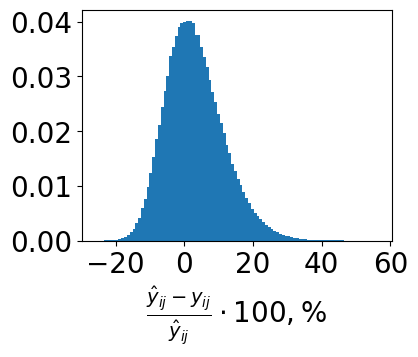

In [105]:
fig,ax = plot_float_distribution(errors_)
ax.set_title('')
ax.set_xlabel(r'$\frac{\hat{y}_{ij}-y_{ij}}{\hat{y}_{ij}} \cdot 100,\%$')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
fig.savefig(os.path.join(path_to_save, 'rel_errors.png'), bbox_inches = 'tight')

In [29]:
print(positions.shape)
torch.save(positions, config.Phi_vector_representation)

(1000, 3)


In [107]:
colors_ = ['b' for i in range(len(positions))]
unique_labels_colors_ = ['b']
unique_labels_ = [0]

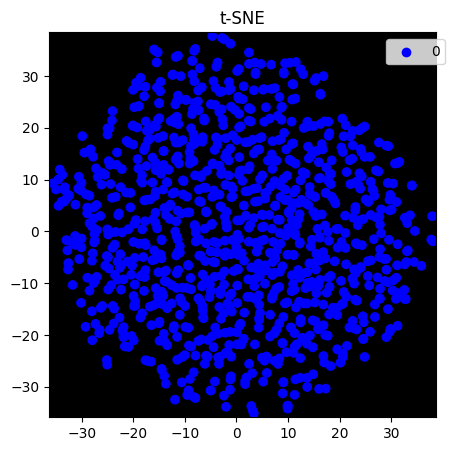

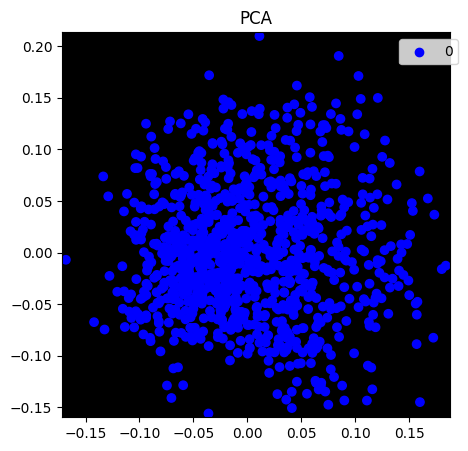

In [108]:
dim_reduction_alg1 = manifold.TSNE(n_components=2)
dim_reduction_alg2 = decomposition.PCA(n_components=2)
positions_1 = dim_reduction_alg1.fit_transform(positions)
positions_2 = dim_reduction_alg2.fit_transform(positions)
N_ = len(positions)
fig,ax1 = graph_layout.cluster_plot((5,5), positions_1, colors_of_points=colors_,color_for_labels=unique_labels_colors_,labels_for_colors=unique_labels_)
fig,ax2 = graph_layout.cluster_plot((5,5), positions_2, colors_of_points=colors_,color_for_labels=unique_labels_colors_,labels_for_colors=unique_labels_)
ax1.set_title('t-SNE')
ax2.set_title('PCA')
plt.show()

compute quality criterion of p

In [12]:
mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
# all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]

In [13]:
shared_integration_supports = Integrator(dir_=config.integrator_dir,
                                        shared_data=mg.shared_data,
                                        clear_cache=True).shared_integration_supports


     num_of_rect_in_intersection 17090


In [14]:
all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]
nr = len(all_p[0].z_list)
uniform_distrib_of_rules= np.ones(shape=(nr,))/nr
a, h, f, coeff_list = mg.shared_data['ahfcoeff_list']
for i in range(N):
    all_p[i] = renormolize_distribution(all_p[i],[a[el].detach().numpy() for el in range(len(a))],uniform_distrib_of_rules)

In [15]:
L = np.zeros(shape=(N,))
for i in range(N):
    p_ = all_p[i]
    L_i = get_L2_Distrib4D(p_, shared_integration_supports)
    L[i] = L_i
    print(L_i)

0.837760055191844
0.8095232583419064
0.8218938980967648
0.8194822156766682
0.8327775055922417
0.8376786149573779
0.8393879773773929
0.8342827602680427
0.8355680199804948
0.8041713306165864
0.8306740065625374
0.8186131187588311
0.8330630902888491
0.7435794878001897
0.8440957935111709
0.822454955302179
0.8296874121018871
0.8820032848321389
0.8330441075401325
0.8294308764667184
0.8586063274135962
0.8388516348352688
0.8259933401024726
0.8334777560156366
0.8358057117545168
0.8421637424780404
0.830469597890385
0.8277931973865855
0.8331909680706496
0.8310741090979223
0.839452240903421
0.8232500090426872
0.8290033176636221
0.8258315412377344
0.8409021418252685
0.836676512222471
0.8290100400986989
0.8349406908489994
0.8381527784369526
0.8326874025633316
0.838538710669472
0.8518058208908305
0.8296209803505978
0.8295179443821022
0.8270138982776086
0.8260115481029935
0.8861952943158906
0.8383701515654332
0.7942138257327526
0.8207691993138213
0.8177431429306706
0.8332035246662484
0.8366704106179428

0.7236017028434074 0.9565942077619904
best p 731 worst p 877
distance_between_best_and_worst 0.37341052709109135


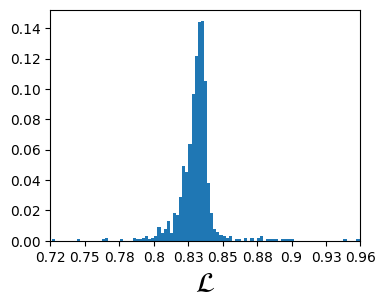

In [56]:
fig6,ax6 = plot_float_distribution(L)
min_L = min(L)
max_L = max(L)
ax6.set_xlim(min_L,max_L)
ax6.set_title('')
ax6.set_xlabel(r'$\mathcal{L}$')
ax6.xaxis.label.set_fontsize(20)
x_ticks = np.linspace(min_L,max_L, 10)
ax6.set_xticks(x_ticks)
ax6.set_xticklabels([latex_float(el,2) for el in x_ticks])
# plt.savefig(fig6,os.path.join(config.task_dir, 'distrib_of_loss_by_random_gen.png'))
fig6.savefig(os.path.join(config.task_dir, 'distrib_of_loss_by_random_gen.png'),bbox_inches='tight')
print(min(L),max(L))
argsort_L = np.argsort(L)
print('best p {} worst p {}'.format(argsort_L[0],argsort_L[-1]))
distance_between_best_and_worst = adj_m[argsort_L[0]][argsort_L[-1]]
print('distance_between_best_and_worst {}'.format(distance_between_best_and_worst))

In [17]:
torch.save(L, os.path.join(config.task_dir, 'L2_for_Phi.txt'))

In [109]:
positions = torch.load(config.Phi_vector_representation)
print(positions.shape)

(1000, 23)


In [110]:
L = torch.load(os.path.join(config.task_dir, 'L2_for_Phi.txt'))

In [111]:
dim_reduction_alg1 = manifold.TSNE(n_components=2)
dim_reduction_alg2 = decomposition.PCA(n_components=2)
# dim_reduction_alg2 = decomposition.TruncatedSVD(n_components=2)
positions_1 = dim_reduction_alg1.fit_transform(positions)
positions_2 = dim_reduction_alg2.fit_transform(positions)
print(positions_1.shape)

(1000, 2)


0.7236017028434074 0.9565942077619904


(<Figure size 400x300 with 1 Axes>,
 <Axes: title={'center': '. n of unique values 1000'}, xlabel='nan rate 0.0'>)

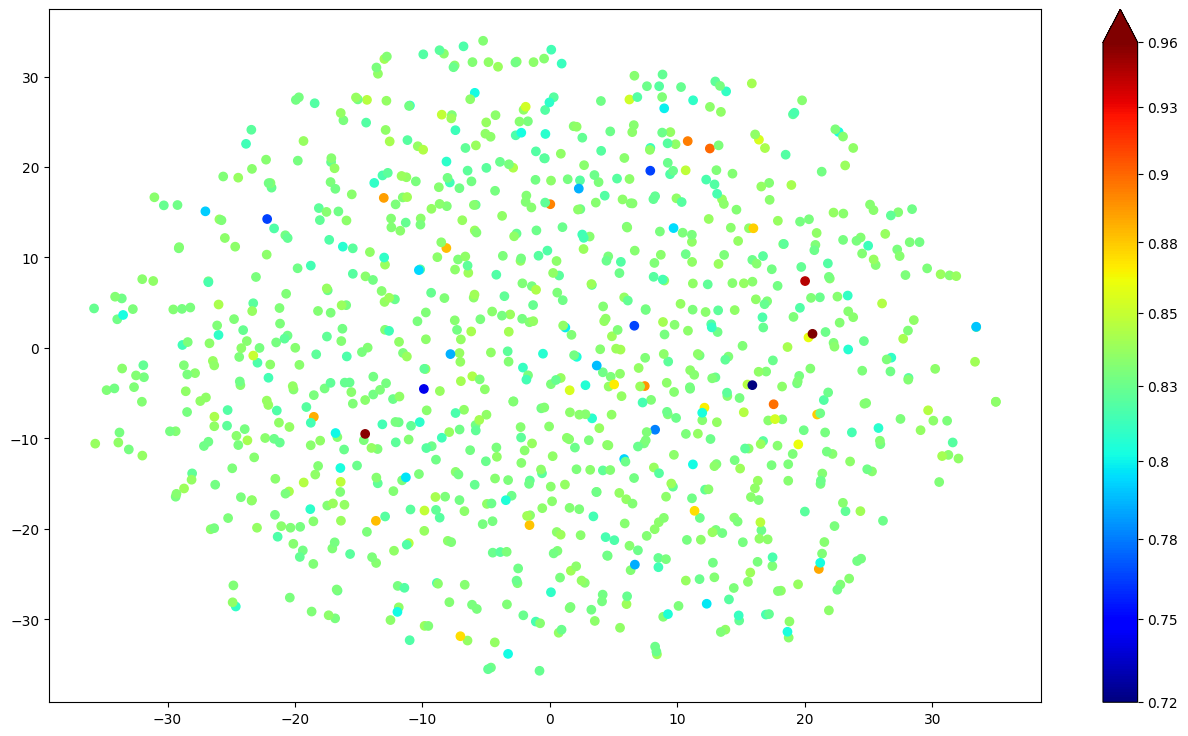

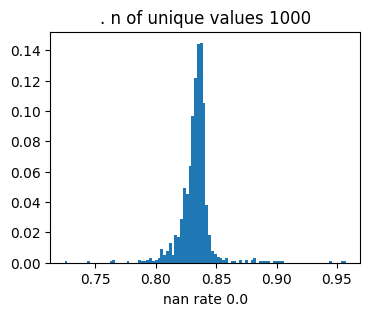

In [112]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
# L_sorted = np.sort(L-np.min(L))
# L_ = L-np.min(L)+L_sorted[1]
# print(L_sorted[1])
L_ = L
# L_ = L
# L_ = np.log(L_)
# norm = matplotlib.colors.Normalize(vmin=min(L_), vmax=max(L_))
# norm = matplotlib.colors.LogNorm(vmin=min(L_), vmax=max(L_))
norm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=min(L_), vmax=max(L_), base=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.jet)
ax.scatter(x = [positions_1[i][0] for i in range(N)],y= [positions_1[i][1] for i in range(N)],c=[m.to_rgba(L_ [i]) for i in range(N)])
cbar = fig.colorbar(m, ax=ax,extend='max',ticks= np.linspace(np.min(L_),np.max(L_),10))
cbar.ax.set_yticklabels([latex_float(i) for i in np.linspace(np.min(L_),np.max(L_),10)])
print(min(L_),max(L_))
plot_float_distribution(L_)

0.7236017028434074 0.9565942077619904


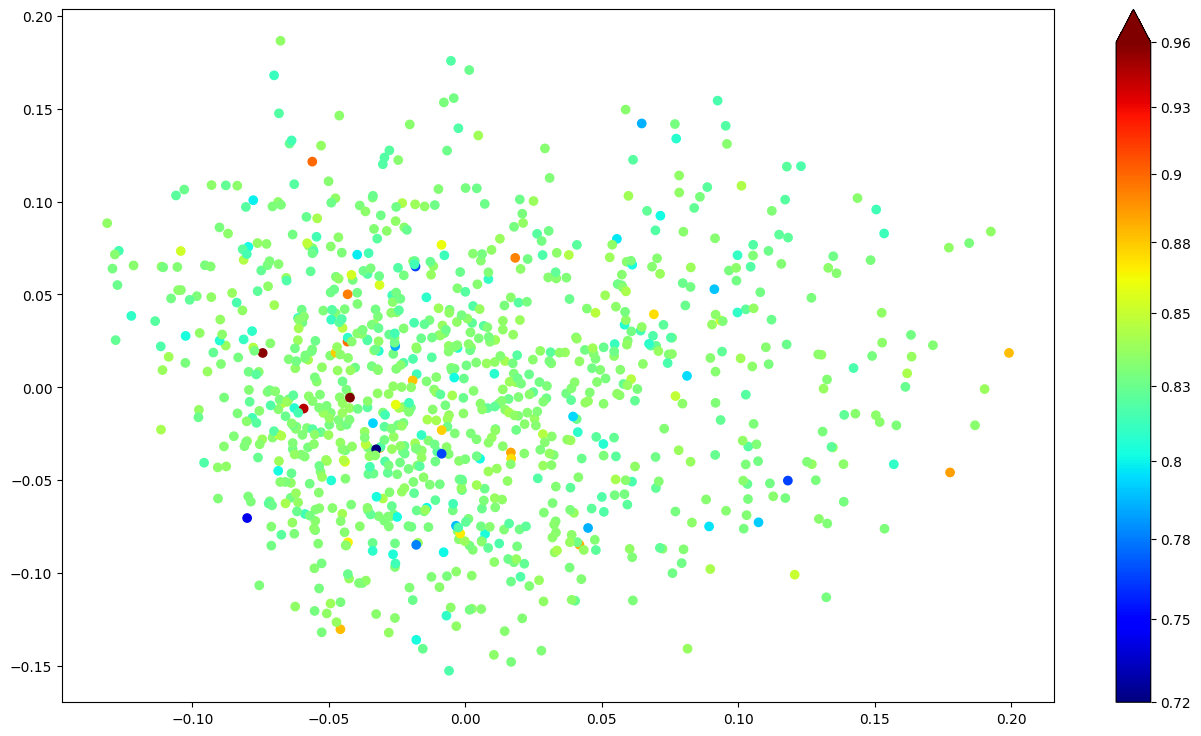

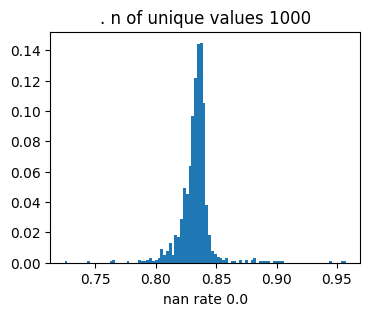

In [113]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
# L_sorted = np.sort(L-np.min(L))
# L_ = L-np.min(L)+L_sorted[1]
# print(L_sorted[1])
L_ = L
# L_ = L
# L_ = np.log(L_)
# norm = matplotlib.colors.Normalize(vmin=min(L_), vmax=max(L_))
# norm = matplotlib.colors.LogNorm(vmin=min(L_), vmax=max(L_))
norm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=min(L_), vmax=max(L_), base=10)
m = cm.ScalarMappable(norm=norm, cmap=cm.jet)
ax.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],c=[m.to_rgba(L_ [i]) for i in range(N)])
cbar = fig.colorbar(m, ax=ax,extend='max',ticks= np.linspace(np.min(L_),np.max(L_),10))
cbar.ax.set_yticklabels([latex_float(i) for i in np.linspace(np.min(L_),np.max(L_),10)])
print(min(L_),max(L_))
plot_float_distribution(L_)
fig.savefig('./surf_of_Loss.png')

save points for latex plot

In [23]:
print(positions_2.shape)

(1000, 2)


In [114]:
hull = ConvexHull(positions_2)

In [115]:
print(len(np.array(hull.simplices,dtype=np.intc).flatten()))

30


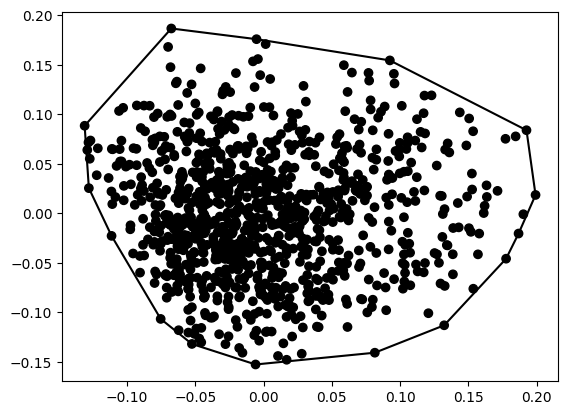

In [116]:
fig3,ax3 = plt.subplots()
for simplex in hull.simplices:
    points = positions_2[simplex]
    x_j = [el[0] for el in points]
    y_j = [el[1] for el in points]
    ax3.plot(x_j,y_j,c='k')
ax3.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],
            color=[(0,0,0) for i in range(N)])
fig3.savefig(os.path.join(path_to_save,'SolutionOnAPlane.png'))

In [52]:
hull_big = ConvexHull(positions)

In [71]:
print(len(hull_big.simplices))

156


In [72]:
all_vertexes=[]
for simplex in hull_big.simplices:
    for j in range(len(simplex)):
        all_vertexes.append(simplex[j])

In [73]:
support_vertexes = np.unique(all_vertexes)
print(support_vertexes)
print(len(support_vertexes))

[  0   4  49  77 108 115 120 130 143 161 181 218 219 281 290 309 314 316
 329 336 343 349 353 361 363 386 389 409 426 432 443 457 463 497 499 529
 534 547 563 578 600 605 606 608 621 623 644 647 655 687 721 730 731 733
 762 803 815 834 837 868 877 878 881 893 896 904 913 926 947 959 960 961
 964 968 973 980 985 990 992 993]
80


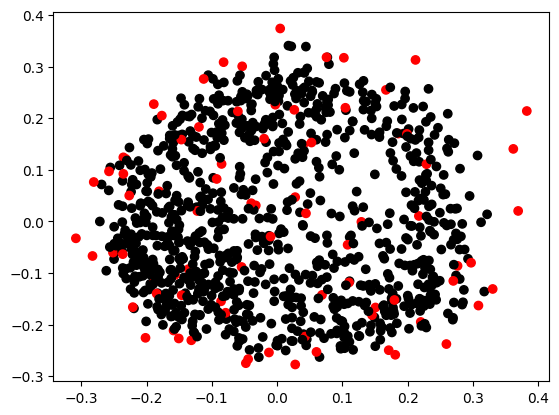

In [75]:
fig4,ax4 = plt.subplots()
support_vertexes_x = [positions_2[el][0] for el in support_vertexes]
support_vertexes_y = [positions_2[el][1] for el in support_vertexes]
colors = []
for i in range(N):
    if i in support_vertexes:
        colors.append((1,0,0))
    else:
        colors.append((0,0,0))
ax4.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],
            color=colors)

In [76]:
torch.save(support_vertexes, os.path.join(config.task_dir, 'support_points.txt'))

In [24]:
tri = Delaunay(positions_2)

In [25]:
print(len(tri.simplices))

1979


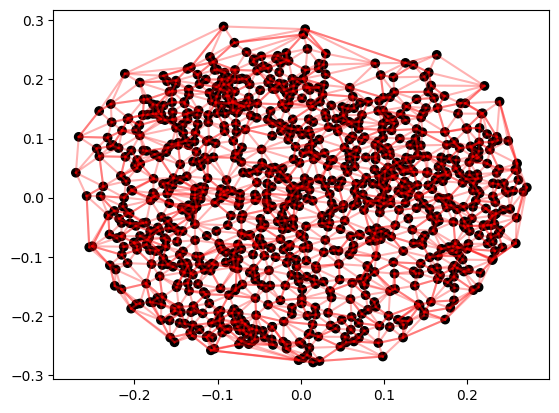

In [26]:
fig5,ax5 = plt.subplots()
for simplex in tri.simplices:
    x_ = []  
    y_ = []
    for j in range(len(simplex)):
        x_.append(positions_2[simplex[j]][0])
        y_.append(positions_2[simplex[j]][1])
    for j in range(len(x_)-1):
        x_plot = [x_[j],x_[j+1]]
        y_plot = [y_[j],y_[j+1]]
        ax5.plot(x_plot,y_plot,color=(1,0,0,0.3))


ax5.scatter(x = [positions_2[i][0] for i in range(N)],y= [positions_2[i][1] for i in range(N)],
            color=[(0,0,0) for i in range(N)])
fig5.savefig('./triangulation.png')

22700
[[760  98  32 670 193]
 [165 590 799  32 411]
 [339 168 904  86 996]
 ...
 [271 120 449 924  61]
 [271  84 120 449  61]
 [271  84 120 449 924]]


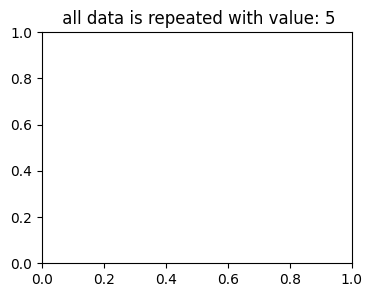

In [27]:
big_tri = Delaunay(positions)
lengs = [len(el) for el in big_tri.simplices]
plot_float_distribution(lengs)
print(len(big_tri.simplices))
print(big_tri.simplices)
torch.save(big_tri.simplices,os.path.join(config.task_dir, 'triangulation_simplexes.txt'))